# FFNN analysis on well-log

functions used for this task are described in the source folder, namely ffnn_well_data_preprocessing.py and ffnn_model.py

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from source.ffnn_model import WellLogFFNN
from source.ffnn_well_data_preprocessing import load_log_data

# Reproducibility, gotten from project 2
NP_RANDOM_SEED = 42
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)


In [2]:
# Load and preprocess data
(X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)



[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Shapes:
X_train: torch.Size([8699, 11])
y_train: torch.Size([8699, 1])
X_val: torch.Size([1864, 11])
X_test: torch.Size([1865, 11])


In [3]:
# Basic statistics of y_train
print("y_train min:", y_train.min().item())
print("y_train max:", y_train.max().item())
print("y_train mean:", y_train.mean().item())
print("y_train std:", y_train.std().item())


y_train min: -5.145756244659424
y_train max: 3.1145031452178955
y_train mean: 0.0
y_train std: 1.0000574588775635


## Defining model and training function.

The model is a feedforward neural network defined in source/ffnn_model.py.

The training function uses MSE loss and Adam optimizer.

Code is adapted from project 2 part c.

In [4]:
input_dim = X_train.shape[1]

# Defining model
def make_model(hidden_dims=(64, 64), dropout=0.2, activation=nn.ReLU):
    return WellLogFFNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    )
# Training function
def train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr: float = 1e-3,
    epochs: int = 100,
    verbose: bool = False,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state_dict = None

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:4d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss:.4f}")

    # last best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, best_val_loss, train_losses, val_losses


In [5]:
# Training with different configurations and evaluating on test set
configs = [
    {"name": "small_no_dropout",  "hidden_dims": (32, 32),        "lr": 1e-3, "dropout": 0.0},
    {"name": "medium_dropout",    "hidden_dims": (64, 64),        "lr": 1e-3, "dropout": 0.2},
    {"name": "deep_dropout",      "hidden_dims": (128, 64, 32),   "lr": 1e-4, "dropout": 0.2},
    {"name": "medium_lr_high",    "hidden_dims": (64, 64),        "lr": 1e-2, "dropout": 0.2},
]

results = []
histories = {}

for cfg in configs:
    print(f"\n=== Training config: {cfg['name']} ===")
    print(f"hidden_dims={cfg['hidden_dims']}, lr={cfg['lr']}, dropout={cfg['dropout']}")

    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)

    model = make_model(
        hidden_dims=cfg["hidden_dims"],
        dropout=cfg["dropout"],
        activation=nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=cfg["lr"],
        epochs=100,
        verbose=False,
    )

    # evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_mse = nn.MSELoss()(y_pred_test, y_test).item()

    results.append({
        "name":        cfg["name"],
        "hidden_dims": cfg["hidden_dims"],
        "lr":          cfg["lr"],
        "dropout":     cfg["dropout"],
        "val_mse":     best_val_mse,
        "test_mse":    test_mse,
    })

    histories[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
    }

results_df = pd.DataFrame(results)
display(results_df)



=== Training config: small_no_dropout ===
hidden_dims=(32, 32), lr=0.001, dropout=0.0

=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2


,name,hidden_dims,lr,dropout,val_mse,test_mse
0,small_no_dropout,"(32, 32)",0.0010,0.0,0.288276,0.298534
1,medium_dropout,"(64, 64)",0.0010,0.2,0.252193,0.257525
2,deep_dropout,"(128, 64, 32)",0.0001,0.2,0.736061,0.751386
3,medium_lr_high,"(64, 64)",0.0100,0.2,0.182292,0.185732


## Objective function for Optuna hyperparameter optimization.


In [6]:
import optuna
from optuna.trial import Trial  


# Define objective function for Optuna
def objective(trial):
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(
        random_state=42
    )    
    
    
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 16, 256, step=16)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 256, step=16)
    hidden_dim3 = trial.suggest_int("hidden_dim3", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # Build hidden_dims tuple based on n_layers
    hidden_dims_list = [hidden_dim1, hidden_dim2, hidden_dim3][:n_layers]
    hidden_dims = tuple(hidden_dims_list)
    
    # Reset seeds for reproducibility
    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)
    
    # Create and train model
    model = make_model(
        hidden_dims=hidden_dims,
        dropout=dropout, 
        activation=nn.ReLU,
    )
    model, best_val_mse, _, _ = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        lr=lr,
        epochs=100,
        verbose=False,
    )
    
    return best_val_mse

# Create and run Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    study_name="ffnn_regression_rs42_new",
    storage="sqlite:///optuna_study.db",
    direction="minimize",
    load_if_exists=False,
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"Best validation MSE: {best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("="*60)

/workspaces/project3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Optuna hyperparameter optimization...


[I 2025-12-18 10:31:29,594] A new study created in RDB with name: ffnn_regression_rs42_new
  0%|          | 0/50 [00:00<?, ?it/s]

[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.321448:   2%|▏         | 1/50 [00:01<00:49,  1.00s/it]

[I 2025-12-18 10:31:30,593] Trial 0 finished with value: 0.32144829630851746 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 16, 'hidden_dim3': 96, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.001127199057650572}. Best is trial 0 with value: 0.32144829630851746.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 1. Best value: 0.235927:   4%|▍         | 2/50 [00:03<01:44,  2.17s/it]

[I 2025-12-18 10:31:33,589] Trial 1 finished with value: 0.2359265685081482 and parameters: {'hidden_dim1': 80, 'hidden_dim2': 48, 'hidden_dim3': 256, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.0021597003182609923}. Best is trial 1 with value: 0.2359265685081482.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 1. Best value: 0.235927:   6%|▌         | 3/50 [00:12<04:04,  5.19s/it]

[I 2025-12-18 10:31:42,377] Trial 2 finished with value: 0.2905651330947876 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 224, 'hidden_dim3': 32, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.0005417370974957024}. Best is trial 1 with value: 0.2359265685081482.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.226092:   8%|▊         | 4/50 [00:15<03:17,  4.30s/it]

[I 2025-12-18 10:31:45,308] Trial 3 finished with value: 0.2260921150445938 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 48, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.007440874167506709}. Best is trial 3 with value: 0.2260921150445938.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.226092:  10%|█         | 5/50 [00:22<03:59,  5.31s/it]

[I 2025-12-18 10:31:52,414] Trial 4 finished with value: 0.31454482674598694 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 128, 'hidden_dim3': 48, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 0.00018688111448166402}. Best is trial 3 with value: 0.2260921150445938.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.226092:  12%|█▏        | 6/50 [00:28<03:55,  5.34s/it]

[I 2025-12-18 10:31:57,816] Trial 5 finished with value: 0.7284101247787476 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 192, 'hidden_dim3': 16, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.00010145436657243364}. Best is trial 3 with value: 0.2260921150445938.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.166934:  14%|█▍        | 7/50 [00:33<03:44,  5.23s/it]

[I 2025-12-18 10:32:02,808] Trial 6 finished with value: 0.1669338494539261 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 240, 'hidden_dim3': 32, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.002191950010897482}. Best is trial 6 with value: 0.1669338494539261.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.166934:  16%|█▌        | 8/50 [00:39<03:56,  5.64s/it]

[I 2025-12-18 10:32:09,333] Trial 7 finished with value: 0.18340767920017242 and parameters: {'hidden_dim1': 80, 'hidden_dim2': 128, 'hidden_dim3': 144, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0017585448782077699}. Best is trial 6 with value: 0.1669338494539261.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.166934:  18%|█▊        | 9/50 [00:43<03:25,  5.02s/it]

[I 2025-12-18 10:32:12,996] Trial 8 finished with value: 0.3040969967842102 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 112, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0005645904025689542}. Best is trial 6 with value: 0.1669338494539261.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.166934:  20%|██        | 10/50 [00:50<03:46,  5.66s/it]

[I 2025-12-18 10:32:20,074] Trial 9 finished with value: 0.18460220098495483 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 64, 'hidden_dim3': 32, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.005419448367680557}. Best is trial 6 with value: 0.1669338494539261.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.166934:  22%|██▏       | 11/50 [00:58<04:03,  6.24s/it]

[I 2025-12-18 10:32:27,640] Trial 10 finished with value: 0.8334136009216309 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 256, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 1.2947901185314791e-05}. Best is trial 6 with value: 0.1669338494539261.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.153981:  24%|██▍       | 12/50 [01:02<03:35,  5.66s/it]

[I 2025-12-18 10:32:31,975] Trial 11 finished with value: 0.1539810746908188 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 176, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0028621247871166862}. Best is trial 11 with value: 0.1539810746908188.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  26%|██▌       | 13/50 [01:07<03:24,  5.51s/it]

[I 2025-12-18 10:32:37,148] Trial 12 finished with value: 0.14110426604747772 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 176, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.003845082474797877}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  28%|██▊       | 14/50 [01:12<03:12,  5.34s/it]

[I 2025-12-18 10:32:42,074] Trial 13 finished with value: 0.14358071982860565 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 176, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.005168715421719103}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  30%|███       | 15/50 [01:22<03:51,  6.61s/it]

[I 2025-12-18 10:32:51,626] Trial 14 finished with value: 0.14329135417938232 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 176, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.009273565447798133}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  32%|███▏      | 16/50 [01:32<04:22,  7.71s/it]

[I 2025-12-18 10:33:01,898] Trial 15 finished with value: 0.15473440289497375 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 208, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.009563340104717407}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  34%|███▍      | 17/50 [01:43<04:52,  8.85s/it]

[I 2025-12-18 10:33:13,415] Trial 16 finished with value: 0.4445846974849701 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 160, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.1, 'lr': 5.088016258259462e-05}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  36%|███▌      | 18/50 [01:51<04:30,  8.45s/it]

[I 2025-12-18 10:33:20,916] Trial 17 finished with value: 0.1993914395570755 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 96, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0009967905849052792}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  38%|███▊      | 19/50 [02:01<04:41,  9.09s/it]

[I 2025-12-18 10:33:31,511] Trial 18 finished with value: 0.15501458942890167 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 160, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.003572953214566962}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  40%|████      | 20/50 [02:05<03:45,  7.51s/it]

[I 2025-12-18 10:33:35,345] Trial 19 finished with value: 0.261923223733902 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 208, 'hidden_dim3': 112, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.00029964172550815796}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  42%|████▏     | 21/50 [02:16<04:10,  8.63s/it]

[I 2025-12-18 10:33:46,574] Trial 20 finished with value: 0.1622200757265091 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 144, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0099797345684054}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  44%|████▍     | 22/50 [02:21<03:30,  7.50s/it]

[I 2025-12-18 10:33:51,446] Trial 21 finished with value: 0.14909029006958008 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 176, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.004558624001400177}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  46%|████▌     | 23/50 [02:26<03:02,  6.76s/it]

[I 2025-12-18 10:33:56,479] Trial 22 finished with value: 0.14571505784988403 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 192, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.004390407415768265}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  48%|████▊     | 24/50 [02:37<03:22,  7.78s/it]

[I 2025-12-18 10:34:06,629] Trial 23 finished with value: 0.18091703951358795 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 160, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.001168247814506802}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  50%|█████     | 25/50 [02:42<02:56,  7.05s/it]

[I 2025-12-18 10:34:11,983] Trial 24 finished with value: 0.14828786253929138 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 224, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.00600209029221117}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  52%|█████▏    | 26/50 [02:49<02:46,  6.94s/it]

[I 2025-12-18 10:34:18,656] Trial 25 finished with value: 0.18252144753932953 and parameters: {'hidden_dim1': 48, 'hidden_dim2': 96, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0030516196204038656}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  54%|█████▍    | 27/50 [02:54<02:32,  6.63s/it]

[I 2025-12-18 10:34:24,569] Trial 26 finished with value: 0.19286461174488068 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 192, 'hidden_dim3': 176, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0006480704537267239}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  56%|█████▌    | 28/50 [03:05<02:49,  7.71s/it]

[I 2025-12-18 10:34:34,788] Trial 27 finished with value: 0.922315239906311 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 144, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.1, 'lr': 1.3042710538156122e-05}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  58%|█████▊    | 29/50 [03:08<02:17,  6.53s/it]

[I 2025-12-18 10:34:38,577] Trial 28 finished with value: 0.16847999393939972 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 176, 'hidden_dim3': 128, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0016452493422024301}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  60%|██████    | 30/50 [03:17<02:23,  7.20s/it]

[I 2025-12-18 10:34:47,331] Trial 29 finished with value: 0.2012886255979538 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 208, 'hidden_dim3': 224, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.0012122363474732882}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  62%|██████▏   | 31/50 [03:27<02:30,  7.90s/it]

[I 2025-12-18 10:34:56,874] Trial 30 finished with value: 0.16317836940288544 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 112, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.006633080687310178}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  64%|██████▍   | 32/50 [03:32<02:08,  7.11s/it]

[I 2025-12-18 10:35:02,150] Trial 31 finished with value: 0.15030542016029358 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 192, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.004066180781020701}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  66%|██████▌   | 33/50 [03:37<01:49,  6.44s/it]

[I 2025-12-18 10:35:07,007] Trial 32 finished with value: 0.14374741911888123 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 176, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.004100068305790544}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  68%|██████▊   | 34/50 [03:40<01:25,  5.31s/it]

[I 2025-12-18 10:35:09,699] Trial 33 finished with value: 0.1888865828514099 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 16, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.002498598629261239}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 12. Best value: 0.141104:  70%|███████   | 35/50 [03:49<01:36,  6.46s/it]

[I 2025-12-18 10:35:18,848] Trial 34 finished with value: 0.1587359607219696 and parameters: {'hidden_dim1': 80, 'hidden_dim2': 160, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.009940851003397009}. Best is trial 12 with value: 0.14110426604747772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  72%|███████▏  | 36/50 [03:54<01:26,  6.21s/it]

[I 2025-12-18 10:35:24,451] Trial 35 finished with value: 0.13836131989955902 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 224, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006035062484273623}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  74%|███████▍  | 37/50 [04:03<01:31,  7.01s/it]

[I 2025-12-18 10:35:33,344] Trial 36 finished with value: 0.16535881161689758 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 240, 'hidden_dim3': 176, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.006584258761585982}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  76%|███████▌  | 38/50 [04:14<01:36,  8.01s/it]

[I 2025-12-18 10:35:43,691] Trial 37 finished with value: 0.17316283285617828 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 224, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0018101785616276064}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  78%|███████▊  | 39/50 [04:28<01:48,  9.85s/it]

[I 2025-12-18 10:35:57,821] Trial 38 finished with value: 0.25184404850006104 and parameters: {'hidden_dim1': 48, 'hidden_dim2': 256, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.006901673401249253}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  80%|████████  | 40/50 [04:33<01:25,  8.54s/it]

[I 2025-12-18 10:36:03,299] Trial 39 finished with value: 0.285710871219635 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 240, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.00011267728802972567}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  82%|████████▏ | 41/50 [04:41<01:13,  8.17s/it]

[I 2025-12-18 10:36:10,616] Trial 40 finished with value: 0.23985202610492706 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 144, 'hidden_dim3': 144, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.0008773353869963791}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  84%|████████▍ | 42/50 [04:45<00:57,  7.14s/it]

[I 2025-12-18 10:36:15,337] Trial 41 finished with value: 0.14951738715171814 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 176, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0034600783635616774}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  86%|████████▌ | 43/50 [04:50<00:45,  6.52s/it]

[I 2025-12-18 10:36:20,420] Trial 42 finished with value: 0.1482023149728775 and parameters: {'hidden_dim1': 80, 'hidden_dim2': 208, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.004781149372333899}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  88%|████████▊ | 44/50 [04:55<00:35,  5.93s/it]

[I 2025-12-18 10:36:24,968] Trial 43 finished with value: 0.16017946600914001 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.001953686056142141}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  90%|█████████ | 45/50 [05:01<00:29,  5.98s/it]

[I 2025-12-18 10:36:31,062] Trial 44 finished with value: 0.14358359575271606 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 176, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.007215310325518482}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  92%|█████████▏| 46/50 [05:12<00:30,  7.63s/it]

[I 2025-12-18 10:36:42,549] Trial 45 finished with value: 0.1614193469285965 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 192, 'hidden_dim3': 256, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.008617847867577733}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  94%|█████████▍| 47/50 [05:17<00:20,  6.79s/it]

[I 2025-12-18 10:36:47,385] Trial 46 finished with value: 0.1430608183145523 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 224, 'hidden_dim3': 80, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.006062154244198642}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  96%|█████████▌| 48/50 [05:26<00:14,  7.26s/it]

[I 2025-12-18 10:36:55,728] Trial 47 finished with value: 0.17201657593250275 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 240, 'hidden_dim3': 96, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.002626079194666991}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361:  98%|█████████▊| 49/50 [05:38<00:08,  8.73s/it]

[I 2025-12-18 10:37:07,909] Trial 48 finished with value: 0.1800563782453537 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 224, 'hidden_dim3': 96, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.005226797168714619}. Best is trial 35 with value: 0.13836131989955902.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 35. Best value: 0.138361: 100%|██████████| 50/50 [05:47<00:00,  6.96s/it]

[I 2025-12-18 10:37:17,388] Trial 49 finished with value: 0.688985288143158 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 256, 'hidden_dim3': 80, 'n_layers': 2, 'dropout': 0.4, 'lr': 3.779575116079551e-05}. Best is trial 35 with value: 0.13836131989955902.

OPTUNA OPTIMIZATION RESULTS
Best validation MSE: 0.138361

Best hyperparameters:
  hidden_dim1: 96
  hidden_dim2: 224
  hidden_dim3: 240
  n_layers: 4
  dropout: 0.0
  lr: 0.006035062484273623


## Extract best hyperparameters from Optuna


In [7]:
best_params = best_trial.params

# Build hidden layers tuple
n_layers = best_params["n_layers"]
best_hidden_dims = tuple([
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["hidden_dim3"],
][:n_layers])

best_dropout = best_params["dropout"]
best_lr = best_params["lr"]

print("Using hidden_dims =", best_hidden_dims)
print("dropout =", best_dropout)
print("learning rate =", best_lr)


Using hidden_dims = (96, 224, 240)
dropout = 0.0
learning rate = 0.006035062484273623


Best config: medium_lr_high


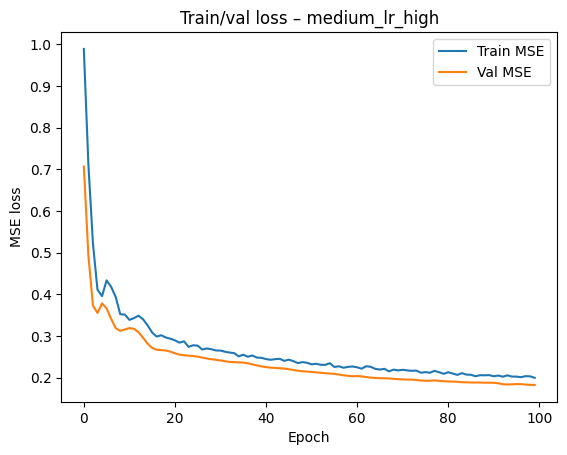

In [8]:
import matplotlib.pyplot as plt

y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled      = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting train/val loss curves for best config
best_name = results_df.sort_values("val_mse").iloc[0]["name"]
print("Best config:", best_name)

train_losses = histories[best_name]["train_losses"]
val_losses   = histories[best_name]["val_losses"]

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Train/val loss – {best_name}")
plt.show()


## FFNN VS RIDGE

Use Optuna best trial to rebuild & retrain the model, then plot preds vs true. 




Best Optuna params: {'hidden_dim1': 96, 'hidden_dim2': 224, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.006035062484273623}
Using hidden_dims = (96, 224, 240) dropout = 0.0 lr = 0.006035062484273623


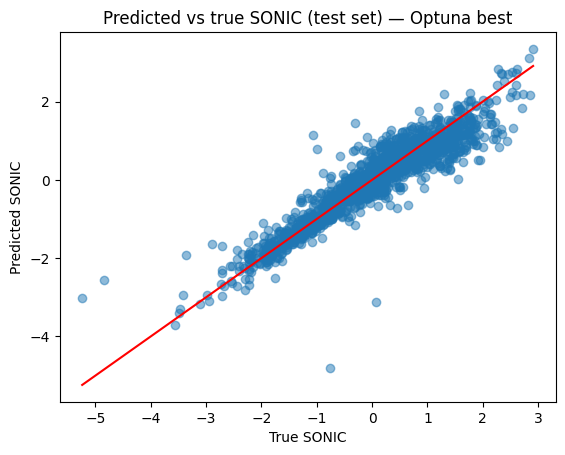

In [9]:
params = best_trial.params
n_layers = params.get("n_layers", 2)
hidden_dims = tuple([params["hidden_dim1"], params["hidden_dim2"], params["hidden_dim3"]][:n_layers])
dropout = params.get("dropout", 0.0)
lr = params.get("lr", 1e-3)

print("Best Optuna params:", params)
print("Using hidden_dims =", hidden_dims, "dropout =", dropout, "lr =", lr)

# Reproducibility
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)

# Build and train model using Optuna params
model = make_model(
    hidden_dims=hidden_dims,
    dropout=dropout,
    activation=nn.ReLU,
)
model, _, _, _ = train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr=lr,
    epochs=100,
    verbose=False,
)

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()
y_true_test = y_test.cpu().numpy()

# Scatter plot
plt.figure()
plt.scatter(y_true_test, y_pred_test, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Optuna best")
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color="red")
plt.show()


Ridge baseline:
Test MSE: 0.36964598298072815
Test R²: 0.6433965563774109


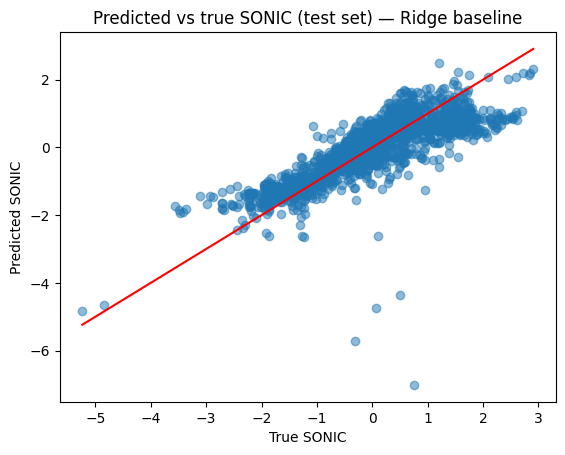

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Convert tensors to numpy
X_tr = X_train.numpy()
y_tr = y_train.numpy().ravel()
X_te = X_test.numpy()
y_te = y_test.numpy().ravel()

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

ridge_pred = ridge.predict(X_te)

ridge_mse = mean_squared_error(y_te, ridge_pred)
ridge_r2  = r2_score(y_te, ridge_pred)

print("Ridge baseline:")
print("Test MSE:", ridge_mse)
print("Test R²:", ridge_r2)

plt.figure()
plt.scatter(y_te, ridge_pred, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Ridge baseline")
plt.plot([y_te.min(), y_te.max()],
            [y_te.min(), y_te.max()], color="red")
plt.show()


## Calculating R² score.

[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 0: R² = 0.8565
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 1: R² = 0.8588
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 2: R² = 0.8430
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 3: R² = 0.8542
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 4: R² = 0.8520


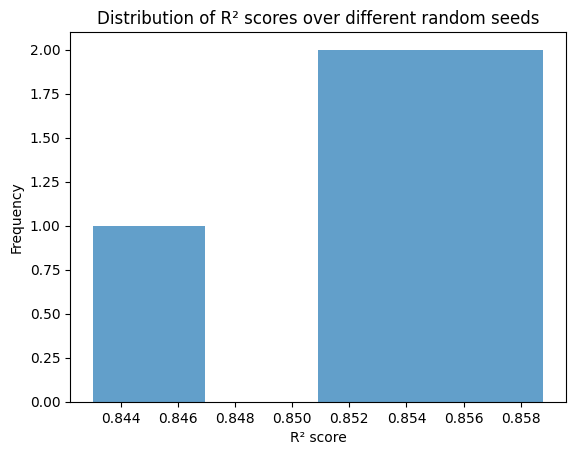

In [ ]:
from sklearn.metrics import r2_score

seeds = [0, 1, 2, 3, 4]
scores = []

for seed in seeds:
    # 1. new random split
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

    # 2. train model with same hyperparameters
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = make_model(  # use best params fra Optuna
        hidden_dims = hidden_dims,
        dropout = best_dropout,
        activation = nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=best_lr,
        epochs=100,
        verbose=False,
    )

    # 3. evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)

    r2 = r2_score(
        y_test.numpy().ravel(),
        y_pred_test.numpy().ravel()
    )
    print(f"Seed {seed}: R² = {r2:.4f}")
    scores.append(r2)

print("R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std  R²:", np.std(scores))

plt.figure()
plt.hist(scores, bins='auto', alpha=0.7)
plt.xlabel("R² score")
plt.ylabel("Frequency")
plt.title("Distribution of R² scores over different random seeds")
plt.show()

